# 1. VAR Process

In the data `raotb16.csv` we have some macroeconomic data.

1. Test which series Granger cause each other.

2. Test which series are stationary

3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima_model import ARIMA

In [38]:
#1.1 Test which series Granger cause each other

df = pd.read_csv('data/raotb16.csv')
df.date = pd.to_datetime(df.date)
df = df.set_index("date")
data = np.log(df).diff().dropna() #taken from lecture notes

In [39]:
#more taken from class
model = VAR(data)
results = model.fit(2)
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, May, 2021
Time:                     02:37:19
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -82.6169
Nobs:                     120.000    HQIC:                  -84.4931
Log likelihood:           3920.38    FPE:                5.68349e-38
AIC:                     -85.7760    Det(Omega_mle):     1.96925e-38
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.013603         0.008575            1.586           0.113
L1.rgnp         -0.004329         0.128555           -0.034           0.973
L1.pgnp          1.299710         4.987128            0.261           0.794
L1.ul

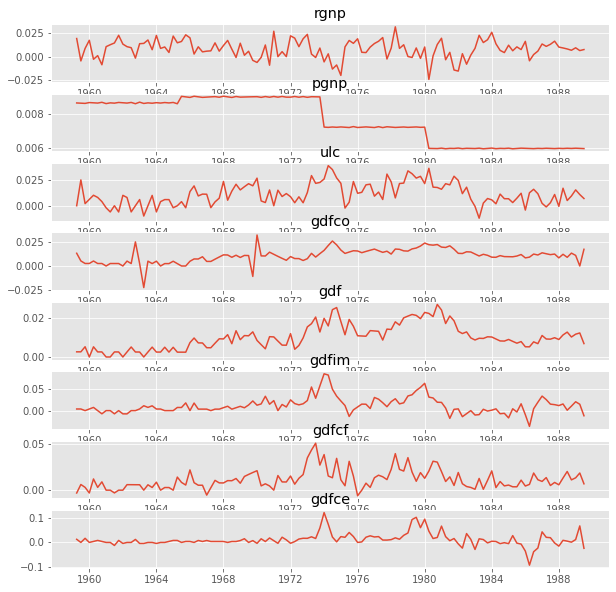

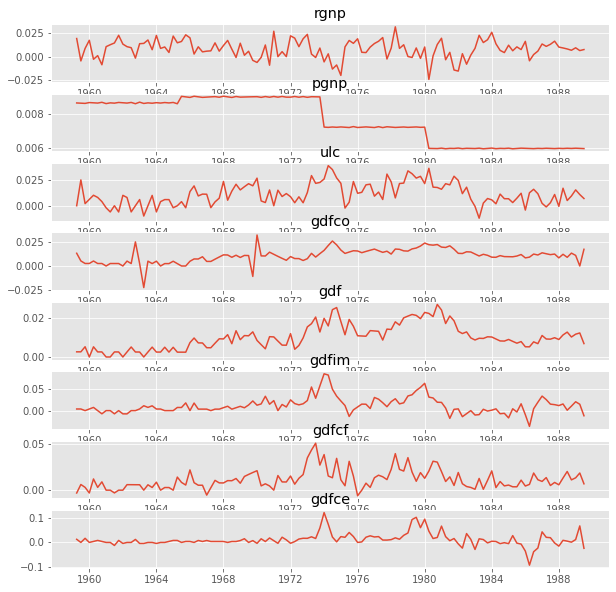

In [43]:
results.plot()

In [47]:
results = model.fit(maxlags=4, ic='aic')

In [56]:
columns = ['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']

for i in columns:
    x = columns.copy()
    x.remove(i)
    print(i, ', ', x)
    print(results.test_causality(i, x, kind='f').summary())

rgnp ,  ['pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: ['pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'] do not Granger-cause rgnp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.941          2.020   0.060 (7, 896)
----------------------------------------------
pgnp ,  ['rgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: ['rgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'] do not Granger-cause pgnp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.304          2.020   0.025 (7, 896)
----------------------------------------------
ulc ,  ['rgnp', 'pgnp', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: ['rgnp', 'pgnp', 'gdfco', 'gdf', 'gdfim', 'gdfcf', '

In [59]:
#1.2 Test which series are stationary
    
for i in data.columns:
    pvalue = adfuller(data[i], autolag="AIC")[1]
    print(pvalue)

1.611359450225909e-06
0.877743548756531
0.028077703276924285
0.34571933145539857
0.40672295719448326
0.0013127995908231134
0.0031642390286744115
3.2503523915834156e-06


**So it can be seen that ulc, gdfcf, and gdfce columns are stationary as they have p-values < 0.05**

In [62]:
# 1.3 Fit a VAR on the system of time series

train = df[:-4]
test = df[-4:]

In [63]:
data = train.diff().dropna()

model = VAR(data)

results = model.select_order(maxlags = 6)
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,2.629,2.823,13.86,2.708
1,-2.917,-1.170*,0.05422,-2.208*
2,-2.756,0.5446,0.06473,-1.417
3,-2.999,1.855,0.05298,-1.029
4,-3.100,3.308,0.05203*,-0.5000
5,-3.085,4.876,0.06079,0.1449
6,-3.167*,6.348,0.06991,0.6937


In [64]:
fitted = model.fit(5)
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, May, 2021
Time:                     02:56:49
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.75304
Nobs:                     113.000    HQIC:                 0.0488776
Log likelihood:          -775.976    FPE:                  0.0557632
AIC:                     -3.16362    Det(Omega_mle):      0.00468608
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            4.878104        24.236347            0.201           0.840
L1.rgnp          0.088839         0.160186            0.555           0.579
L1.pgnp          0.492337         5.264955            0.094           0.925
L1.ul

In [65]:
dw = durbin_watson(fitted.resid)

for x, y in zip(df.columns, dw):
    print(str(x), ':', y)

rgnp : 1.9871021893417662
pgnp : 2.110107109612438
ulc : 1.9024825847826128
gdfco : 1.9932405918627438
gdf : 2.3438757353153226
gdfim : 2.0279839983467194
gdfcf : 2.312390680400651
gdfce : 2.0235005580240215


In [66]:
best_lag_order = fitted.k_ar
best_lag_order

5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


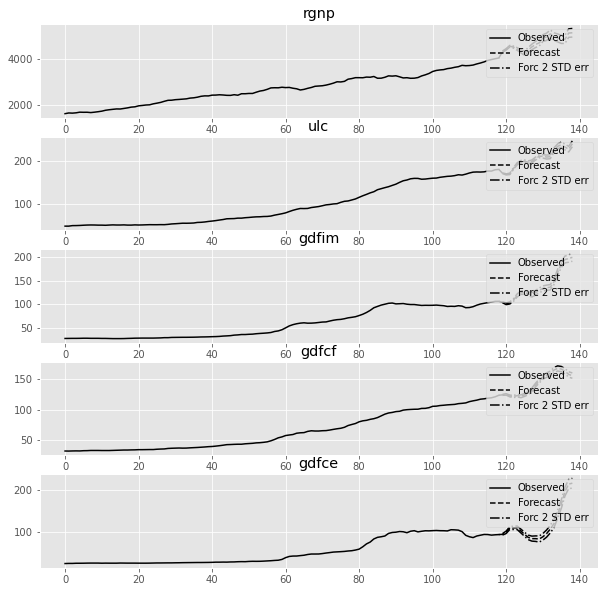

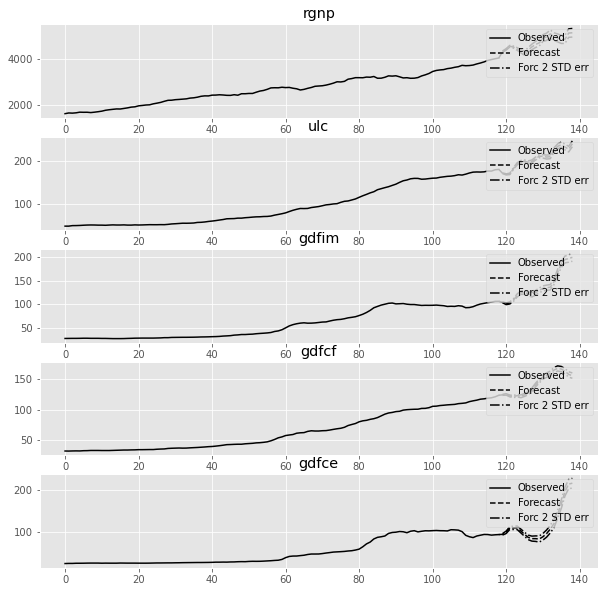

In [70]:
# 1.4 Fit a VAR on everything except the last 12 months (4 quarters) of the data.

cols = ['rgnp', 'ulc', 'gdfim', 'gdfcf', 'gdfce']

#Taken from lecture notes
model = VAR(train[cols])
results = model.fit(maxlags=15, ic='aic')
results.plot_forecast(20)

# 2. Gun Violence Panel

The [Gun Violence](https://www.kaggle.com/jameslko/gun-violence-data) dataset

1. Transform it into an amenable panel (or structure of multiple time series) to analyze and create a forecast for the next year outside the sample in **Chicago**, **Washington** and **New Orleans**, and the US as a whole.

2. Are there other (non time series) predictors which could be used in this dataset to help predict severity or number of shootings in the future? Analyze the data for feature importance and explain your findings.

In [147]:
df = pd.read_csv('data/gunviolence.csv')
df.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district'],
      dtype='object')

In [148]:
data = df[['date','city_or_county', 'n_killed', 'n_injured', 'n_guns_involved']]
data

,date,city_or_county,n_killed,n_injured,n_guns_involved
0,2013-01-01,Mckeesport,0,4,NaN
1,2013-01-01,Hawthorne,1,3,NaN
2,2013-01-01,Lorain,1,3,2.0
3,2013-01-05,Aurora,4,0,NaN
4,2013-01-07,Greensboro,2,2,2.0
...,...,...,...,...,...
239672,2018-03-31,Rayne,0,0,1.0
239673,2018-03-31,Natchitoches,1,0,1.0
239674,2018-03-31,Gretna,0,1,1.0
239675,2018-03-31,Houston,1,0,1.0


In [149]:
data['date'] = data['date'].astype(str)
data['date'] = data['date'].apply(lambda x: '{:%Y}'.format(datetime.strptime(x, '%Y-%m-%d'))) #strip the month and date

<ipython-input-149-8e612b7b0305>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = data['date'].astype(str)
<ipython-input-149-8e612b7b0305>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = data['date'].apply(lambda x: '{:%Y}'.format(datetime.strptime(x, '%Y-%m-%d'))) #strip the month and date


In [150]:
data.date = pd.to_datetime(data.date)
data = data.set_index("date")
data

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,city_or_county,n_killed,n_injured,n_guns_involved
date,,,,
2013-01-01,Mckeesport,0,4,NaN
2013-01-01,Hawthorne,1,3,NaN
2013-01-01,Lorain,1,3,2.0
2013-01-01,Aurora,4,0,NaN
2013-01-01,Greensboro,2,2,2.0
...,...,...,...,...
2018-01-01,Rayne,0,0,1.0
2018-01-01,Natchitoches,1,0,1.0
2018-01-01,Gretna,0,1,1.0


In [165]:
#Separate Chicago, New Orleans and Washington and groupby

chicago = data.loc[data['city_or_county'] == 'Chicago'].groupby('date').sum()
washington = data.loc[data['city_or_county'] == 'Washington'].groupby('date').sum()
new_orleans = data.loc[data['city_or_county'] == 'New Orleans'].groupby('date').sum()

In [155]:
chicago

,n_killed,n_injured,n_guns_involved
date,,,
2013-01-01,6,71,4.0
2014-01-01,414,1893,225.0
2015-01-01,432,2339,1186.0
2016-01-01,591,2962,2395.0
2017-01-01,574,2730,2914.0
2018-01-01,87,432,516.0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JA

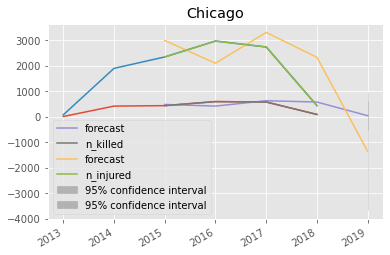

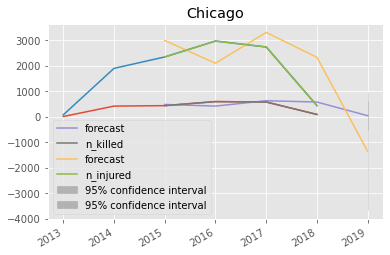

In [159]:
#Plot time series of killed and injured people in each state

model = ARIMA(chicago.n_killed, order=(2, 1, 0))
model2 = ARIMA(chicago.n_injured, order=(2, 1, 0))

res = model.fit(disp=-1)
res2 = model2.fit(disp = -1)

fig, ax = plt.subplots()
ax.plot(chicago.n_killed)
ax.plot(chicago.n_injured)
ax.set_title("Chicago")

res.plot_predict('2015', '2019', ax=ax)
res2.plot_predict('2015', '2019', ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JA

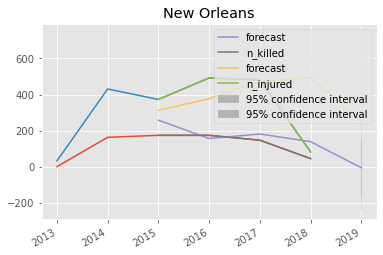

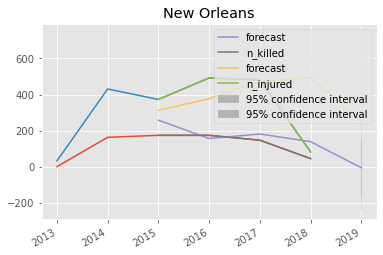

In [167]:
model = ARIMA(new_orleans.n_killed, order=(2, 1, 0))
model2 = ARIMA(new_orleans.n_injured, order=(2, 1, 0))

res = model.fit(disp=-1)
res2 = model2.fit(disp = -1)

fig, ax = plt.subplots()
ax.plot(new_orleans.n_killed)
ax.plot(new_orleans.n_injured)
ax.set_title("New Orleans")

res.plot_predict('2015', '2019', ax=ax)
res2.plot_predict('2015', '2019', ax=ax)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JA

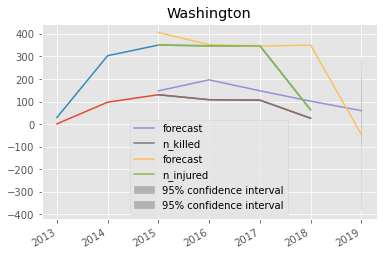

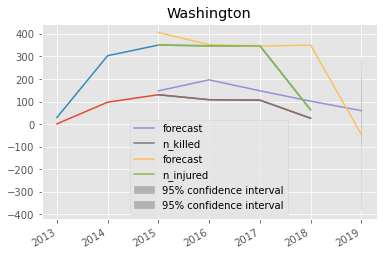

In [168]:
model = ARIMA(washington.n_killed, order=(2, 1, 0))
model2 = ARIMA(washington.n_injured, order=(2, 1, 0))

res = model.fit(disp=-1)
res2 = model2.fit(disp = -1)

fig, ax = plt.subplots()
ax.plot(washington.n_killed)
ax.plot(washington.n_injured)
ax.set_title("Washington")

res.plot_predict('2015', '2019', ax=ax)
res2.plot_predict('2015', '2019', ax=ax)

In [185]:
#Now for the whole USA
data = df[['date','city_or_county', 'n_killed', 'n_injured', 'n_guns_involved']]
data['date'] = data['date'].astype(str)
data['date'] = data['date'].apply(lambda x: '{:%Y}'.format(datetime.strptime(x, '%Y-%m-%d'))) #strip the month and date
data.date = pd.to_datetime(data.date)
data = data.set_index("date")

<ipython-input-185-a03fb2235763>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = data['date'].astype(str)
<ipython-input-185-a03fb2235763>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = data['date'].apply(lambda x: '{:%Y}'.format(datetime.strptime(x, '%Y-%m-%d'))) #strip the month and date


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JA

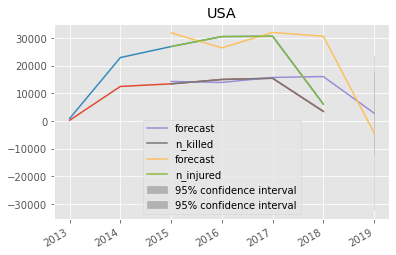

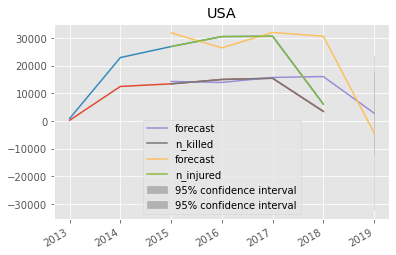

In [186]:
data = data.groupby('date').sum()


model = ARIMA(data.n_killed, order=(2, 1, 0))
model2 = ARIMA(data.n_injured, order=(2, 1, 0))

res = model.fit(disp=-1)
res2 = model2.fit(disp = -1)

fig, ax = plt.subplots()
ax.plot(data.n_killed)
ax.plot(data.n_injured)
ax.set_title("USA")

res.plot_predict('2015', '2019', ax=ax)
res2.plot_predict('2015', '2019', ax=ax)

In [187]:
#Are there other (non time series) predictors which could be used in this dataset to help predict severity or number of 
#shootings in the future? Analyze the data for feature importance and explain your findings.

df.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district'],
      dtype='object')

**Looking at all the columns in the dataset, it can be seen that there are certain missing factors such as shooter's demographic details which could possibly help identify the next shooter.**

**The location information of the shootings can be potentially helpful in order to identify the next possible location for a shooting**

**Information about gun laws in areas of shootings can also help identify the root of the issue**

**there is a gun_stolen column but if that were expanded to a column that says how the gun was obtained, there could be good information as to how shooters usually obtain guns in the places incidents occur (i.e legal purchase, stolen gun, blackmarket etc)**